In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee
import astropy
from astropy.io import ascii
from astropy import units
from astropy.coordinates import SkyCoord

# utilities

In [2]:
def sdss_to_des_Y1A1(g_sdss,r_sdss,i_sdss,z_sdss,y_sdss):
    """
    transfrom equation given by [arXiv:1708.01531].
    """
    ret = {}
    ret["g_des"] = g_sdss - 0.104*(g_sdss-r_sdss) + 0.01
    ret["r_des"] = g_sdss - 0.102*(g_sdss-r_sdss) + 0.02
    ret["i_des"] = i_sdss - 0.256*(i_sdss-z_sdss) + 0.02
    ret["z_des"] = z_sdss - 0.086*(i_sdss-z_sdss) + 0.01
    ret["y_des"] = y_sdss + 0.238*(z_sdss-y_sdss) + 0.483
    ret["VALID"] = (g_sdss - r_sdss < 1.2)["G-R_SDSS"]<1.2
    
    return ret

def des_to_sdss_Y1A1(g_des,r_des,i_des,z_des,y_des):
    """
    transfrom equation given by the inversion of [arXiv:1708.01531].
    """
    ret = {}
    ret["g_sdss"] = 1.104*g_des - 0.1042*r_des - 0.008958
    ret["r_sdss"] = 0.1022*g_des + 0.8978*r_des - 0.01898
    ret["i_sdss"] = 1.308*i_des - 0.3084*z_des - 0.02308
    ret["z_sdss"] = 0.1036*i_des + 0.8964*z_des - 0.01104
    ret["y_sdss"] = -0.03236*i_des + 1.312*y_des - 0.28*z_des - 0.6304
    ret["VALID"] = (ret["g_sdss"] - ret["r_sdss"] < 1.2)
    
    return ret

def des_to_sdss_DR1(g_des,r_des,i_des,z_des):
    """
    conversion equation given by:
    https://des.ncsa.illinois.edu/releases/dr1/dr1-faq
    """
    gmi_des = g_des-i_des
    ret = {}
    ret["g_sdss"] = g_des -0.0009 + 0.055*gmi_des # 0.0 <= (g-i)(DES) <= 3.0
    ret["r_sdss"] = r_des -0.0048 + 0.0703*gmi_des #0.0 <= (g-i)(DES) <= 3.0
    ret["i_sdss"] = i_des -0.0065 - 0.0036*gmi_des + 0.02672*gmi_des**2 # 0.0 <= (g-i)(DES) <= 3.0
    ret["z_sdss"] = z_des -0.0438 + 0.02854*gmi_des #0.0 <= (g-i)(DES) <= 3.0
    ret["VALID"] = np.logical_and(0.0<gmi_des,gmi_des<=3.0)
    
    return ret
    
def Johnson_to_sdss_Jordi2006(u_Johnson,b_Johnson,v_Johnson,r_Johnson,i_Johnson):
    U,B,V,R,I = u_Johnson,b_Johnson,v_Johnson,r_Johnson,i_Johnson
    ret = {}
    ret["u-g"]   =      0.750 *(U-B)  + 0.770 *(B-V) + 0.720
    ret["g-V"]   =      0.630 *(B-V)  - 0.124
    ret["g-B"]   =     -0.370 *(B-V)  - 0.124
    ret["g-r"]   =      1.646 *(V-R)  - 0.139
    ret["g-i"]   =     (1.481 *(V-I)  -  0.536)*(V-I <= 1.8) +  (0.83 *(V-I)    + 0.60)*(V-I > 1.8)
    ret["r-i"]   =     1.007*(R-I)  - 0.236 
    ret["r-z"]   =     1.584*(R-I)  - 0.386
    ret["r-R"]   =     (0.267*(V-R)  + 0.088)*(V-R <= 0.93) +  (0.77*(V-R)    - 0.37)*(V-R > 0.93)
    ret["i-I"]   =     0.247*(R-I)  + 0.329
    return ret

def sdss_to_Johnson_Jordi2006(u_sdss,g_sdss,r_sdss,i_sdss,z_sdss):
    u,g,r,i,z = u_sdss,g_sdss,r_sdss,i_sdss,z_sdss
    ret = {}
    ret["U-B_1"]   =      0.79*(u-g)    - 0.93
    ret["U-B_2"]   =      0.52*(u-g)    + 0.53*(g-r) - 0.82
    ret["B-g_1"]   =      0.175*(u-g)  + 0.150
    ret["B-g_2"]   =      0.313*(g-r)  + 0.219
    ret["V-g"]   =     -0.565*(g-r) - 0.016
    ret["V-I"]   =     (0.675*(g-i)  + 0.364)*(g-i <= 2.1)  + (1.11*(g-i)  - 0.52)*(g-i > 2.1)
    ret["R-r"]   =     -0.153*(r-i) - 0.117
    ret["R-I"]   =      0.930*(r-i)  + 0.259
    ret["I-i"]   =     -0.386*(i-z) - 0.397
    
    ret["R_Johnson"] = ret["R-r"] + r_sdss
    ret["I_Johnson"] = ret["I-i"] + i_sdss
    ret["B_Johnson"] = ret["B-g_1"] + g_sdss
    ret["V_Johnson"] = ret["V-g"] + g_sdss
    ret["U_Johnson"] = ret["U-B_1"] + ret["B_Johnson"]
    
    return ret

def sdss_to_Johnson_Jester2005(u_sdss,g_sdss,r_sdss,i_sdss,z_sdss):
    """
    transform equation given by: 
        https://www.sdss.org/dr12/algorithms/sdssUBVRITransform/#Jester2005
    or
        https://arxiv.org/pdf/astro-ph/0506022.pdf
    
    NOTE: Here we use the relation for 
        "All stars with Rc-Ic < 1.15".
        
    Also note that the following equations are degenerated (5 parameters, but 6 equation)
    """
    ret = {}
    ret["U-B"]    =    0.78*(u_sdss-g_sdss) - 0.88        # res 0.05
    ret["B-V"]    =    0.98*(g_sdss-r_sdss) + 0.22        # res 0.04
    ret["V-R"]    =    1.09*(r_sdss-i_sdss) + 0.22        # res 0.03
    ret["Rc-Ic"]  =    1.00*(r_sdss-i_sdss) + 0.21        # res 0.01
    
    ret["B_Johnson"]      =    g_sdss + 0.39*(g_sdss-r_sdss) + 0.21    # res 0.03
    ret["V_Johnson"]      =    g_sdss - 0.59*(g_sdss-r_sdss) - 0.01    # res 0.01
    
    ret["U_Johnson"] = ret["U-B"] + ret["B_Johnson"]
    ret["I_Johnson"] =  -ret["Rc-Ic"] - ret["V-R"] + ret["V_Johnson"] 
    ret["R_Johnson"] = ret["V_Johnson"] - ret["V-R"]
    ret["VALID"]  =    ret["Rc-Ic"] < 1.15
    
    return ret

def Johnson_to_sdss_Jester2005(u_Johnson,b_Johnson,v_Johnson,r_Johnson,i_Johnson):
    """
    transform equation given by: 
        https://www.sdss.org/dr12/algorithms/sdssUBVRITransform/#Jester2005
    or
        https://arxiv.org/pdf/astro-ph/0506022.pdf
    
    NOTE: Here we use the relation for 
        "All stars with Rc-Ic < 1.15".
        
    Also note that the following equations are degenerated (5 parameters, but 6 equation)
    """
    ret = {}
    ret["u-g"]    =    1.28*(u_Johnson-b_Johnson) + 1.13      #res 0.06
    ret["g-r"]    =    1.02*(b_Johnson-v_Johnson) - 0.22      #res 0.04
    ret["r-i"]    =    0.91*(r_Johnson-i_Johnson) - 0.20      #res 0.03
    ret["r-z"]    =    1.72*(r_Johnson-i_Johnson) - 0.41      #res 0.03
    ret["g"]      =    v_Johnson + 0.60*(b_Johnson-v_Johnson) - 0.12    #res 0.02
    ret["r"]      =    v_Johnson - 0.42*(b_Johnson-v_Johnson) + 0.11    #res 0.03
    ret["VALID"]  =    r_Johnson-i_Johnson < 1.15
    return ret

def sdss_to_Johnson(u_sdss,g_sdss,r_sdss,i_sdss,z_sdss,table="Jordi2006"):
    func = {
        "Jordi2006" :sdss_to_Johnson_Jordi2006,
        "Jester2005":sdss_to_Johnson_Jester2005
    }
    return func[table](u_sdss,g_sdss,r_sdss,i_sdss,z_sdss)

# Conversion

,COADD_OBJECT_ID,RAP,DECP,PSF_G,PSF_R,PSF_I,PSF_Z,PSF_Y,PSFERR_G,PSFERR_R,PSFERR_I,PSFERR_Z,PSFERR_Y,SPREAD_MODEL_G,SPREAD_MODEL_R,SPREAD_MODEL_I,SPREAD_MODEL_Z,SPREAD_MODEL_Y
count,2.943710e+05,294371.000000,294371.000000,294371.000000,294371.000000,294371.000000,294371.000000,294371.000000,294371.000000,294371.000000,294371.000000,294371.000000,294371.000000,294371.000000,294371.000000,294371.000000,294371.000000,294371.000000
mean,2.887017e+08,14.970492,-33.762624,22.016535,20.932542,20.444479,20.197294,20.027648,0.039119,0.015073,0.014415,0.019494,0.059976,-0.966243,0.009704,0.010099,0.010546,0.009648
std,8.106587e+06,1.693516,1.695747,1.497651,1.352614,1.344358,1.357629,1.307124,0.038726,0.011433,0.010521,0.015010,0.050617,529.151143,0.010363,0.010082,0.009899,0.009254
min,2.740504e+08,12.000018,-36.799988,15.025780,14.808887,14.739949,14.618532,14.528670,0.000270,0.000151,0.000095,0.000169,0.000511,-287096.062500,-0.017892,-0.013879,-0.015276,-0.023545
25%,2.814184e+08,13.528497,-35.208503,21.333920,20.380684,19.909561,19.649850,19.507510,0.011786,0.006440,0.006086,0.007540,0.020205,0.000387,0.000504,0.000499,0.000573,0.000640
50%,2.890658e+08,14.973961,-33.729249,22.358517,21.288118,20.826794,20.578066,20.421673,0.026887,0.012959,0.012755,0.016769,0.046154,0.008492,0.009741,0.010474,0.011145,0.009929
75%,2.941090e+08,16.362495,-32.309797,23.104597,21.850588,21.385397,21.165817,20.971315,0.052310,0.020935,0.020663,0.028464,0.086602,0.016088,0.016873,0.017436,0.017969,0.016631
max,3.563767e+08,17.999958,-30.800041,24.592733,23.777979,23.412025,22.792824,22.514748,0.485439,0.209578,0.186387,0.298173,1.044010,1.000000,1.323996,1.000000,1.000000,0.305707


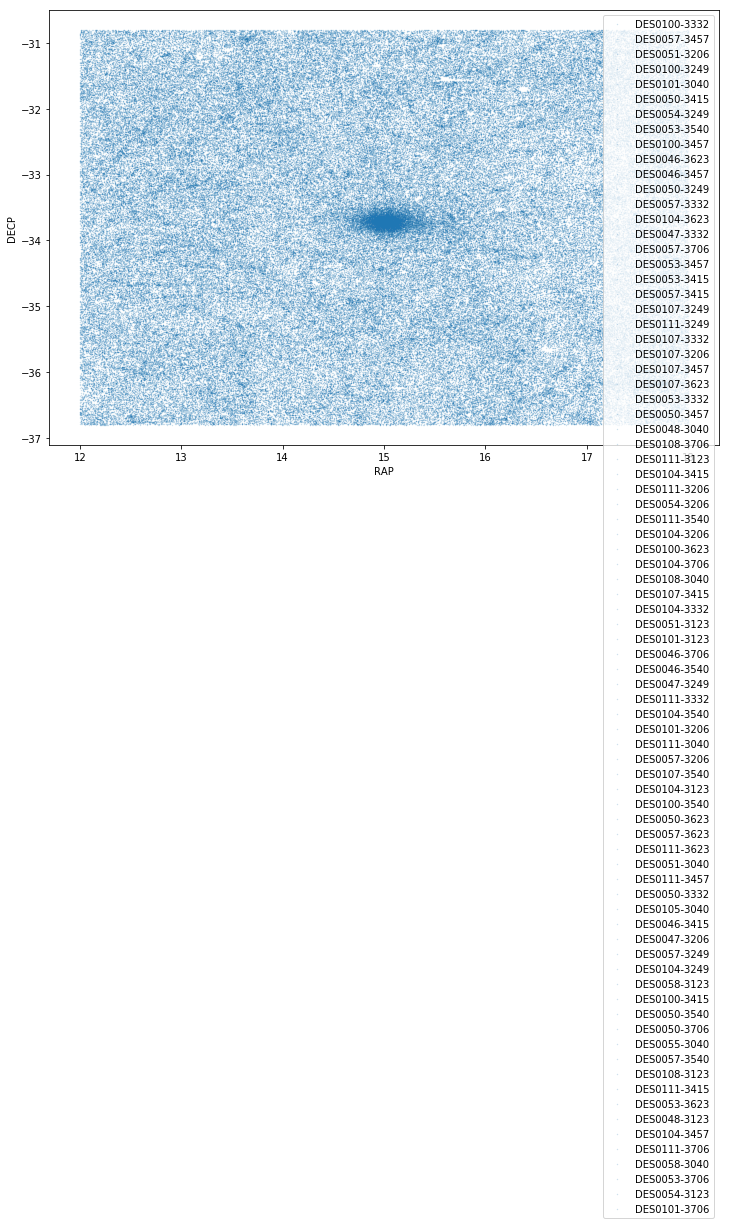

In [14]:
df_des=pd.read_csv("data/des20190121.csv",comment="#")

display(df_des.describe())

#df_des_photometry = df_des[(df_des.PSF_I<50) & (df_des.PSF_G<50)]
PSF_bands = ["PSF_"+band for band in "GRIZY"]
spread_models = ["SPREAD_MODEL_"+band for band in "GRIZY"]

df_des_redden_photometry = df_des[np.prod([df_des[band]<50 for band in PSF_bands],axis=0,dtype=bool)].copy()
df_des_redden_photometry = df_des_redden_photometry[np.prod([np.abs(df_des_redden_photometry[spread_mdl])<0.1 for spread_mdl in spread_models],axis=0,dtype=bool)].copy() # only stars, not galaxies
#df_des_photometry["PSF_G-I"] = df_des_photometry.PSF_G - df_des_photometry.PSF_I
#df_des_photometry["PSF_G-R"] = df_des_photometry.PSF_G - df_des_photometry.PSF_R

fig,ax = plt.subplots(1,1,figsize=(12,8))
cmap = plt.get_cmap("tab10")
for i,tilename in enumerate(df_des.TILENAME.unique()):
    #df_des_photometry[df_des_photometry.TILENAME==tilename].plot.scatter("RAP","DECP",alpha=0.3,s=1,ax=ax,c=cmap(i),label=tilename)
    df_des_redden_photometry[df_des_redden_photometry.TILENAME==tilename].plot.scatter("RAP","DECP",alpha=0.3,s=0.1,ax=ax,c="C0",label=tilename)
#plt.legend()
plt.show()

#df_des_photometry.plot.scatter("PSF_G-I","PSF_I",alpha=0.05,s=0.05)
#plt.ylim([24,14])
#plt.show()

#df_des_photometry.plot.scatter("PSF_G-R","PSF_R",alpha=0.05,s=0.05)
#plt.ylim([24,14])
#plt.show()

#df_des_photometry.plot.scatter("PSF_I","PSFERR_I",alpha=0.1,s=0.01)
#plt.show()

In [9]:
np.unique(np.unique(df_des_photometry.COADD_OBJECT_ID,return_counts=True)[1],return_counts=True)

(array([1]), array([294363]))

,SPREAD_MODEL_G,SPREAD_MODEL_R,SPREAD_MODEL_I,SPREAD_MODEL_Z,SPREAD_MODEL_Y
count,294363.000000,294363.000000,294363.000000,294363.000000,294363.000000
mean,0.009040,0.009689,0.010089,0.010539,0.009646
std,0.009588,0.009567,0.009574,0.009557,0.009233
min,-0.031203,-0.017892,-0.013879,-0.015276,-0.023545
25%,0.000388,0.000504,0.000499,0.000573,0.000640
50%,0.008492,0.009741,0.010474,0.011145,0.009929
75%,0.016088,0.016873,0.017436,0.017969,0.016630
max,0.075093,0.049108,0.044159,0.057410,0.088025


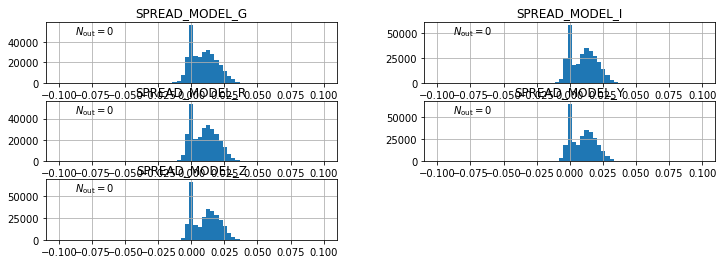

Index(['TILENAME', 'COADD_OBJECT_ID', 'RAP', 'DECP', 'PSF_G', 'PSF_R', 'PSF_I',
       'PSF_Z', 'PSF_Y', 'PSFERR_G', 'PSFERR_R', 'PSFERR_I', 'PSFERR_Z',
       'PSFERR_Y', 'SPREAD_MODEL_G', 'SPREAD_MODEL_R', 'SPREAD_MODEL_I',
       'SPREAD_MODEL_Z', 'SPREAD_MODEL_Y'],
      dtype='object')

In [15]:
bins = np.linspace(-0.1,0.1,64)
spread_models = ["SPREAD_MODEL_G","SPREAD_MODEL_R","SPREAD_MODEL_I","SPREAD_MODEL_Z","SPREAD_MODEL_Y"]
display(df_des_redden_photometry[spread_models].describe())
axes = df_des_redden_photometry[spread_models].hist(bins=bins,figsize=(12,4))
leds = ["{}:$N_\\mathrm{}={}$".format(model,"{out}",(np.abs(df_des_redden_photometry[model])>0.1).sum()) for model in spread_models]
[ax.text(
    s="$N_\\mathrm{}={}$".format("{out}",(np.abs(df_des_redden_photometry[ax.title.get_text()])>0.1).sum()),
    x=0.1,y=0.8,transform=ax.transAxes
) if ax.title.get_text() != "" else None for ax in axes.flatten()]
plt.show()
display(df_des.columns)

In [16]:
# des -> sdss -> Johnson, redden
sdss_from_des_redden  = des_to_sdss_DR1(
    g_des=df_des_redden_photometry.PSF_G,    
    r_des=df_des_redden_photometry.PSF_R,
    i_des=df_des_redden_photometry.PSF_I,
    z_des=df_des_redden_photometry.PSF_Z)
#display(sdss_from_des_redden)
for name,key in zip([band+"_SDSS" for band in "GRIZ"],[band+"_sdss" for band in "griz"]):
    df_des_redden_photometry[name] = sdss_from_des_redden[key]
df_des_redden_photometry["VALID_des_to_sdss"] = sdss_from_des_redden["VALID"]

johnson_redden = sdss_to_Johnson(
    u_sdss=np.nan,
    g_sdss=df_des_redden_photometry["G_SDSS"],
    r_sdss=df_des_redden_photometry["R_SDSS"],
    i_sdss=df_des_redden_photometry["I_SDSS"],
    z_sdss=df_des_redden_photometry["Z_SDSS"],
    table="Jester2005")
johnson = pd.DataFrame(johnson_redden)
johnson_redden
#for key in johnson.keys():
#    df_des_photometry["Johnson_"+key] = johnson[key]
df_des_redden_photometry["Johnson_V-I"] = johnson_redden["V_Johnson"] - johnson_redden["I_Johnson"]
df_des_redden_photometry["Johnson_I"] = johnson_redden["I_Johnson"]
df_des_redden_photometry["Johnson_V"] = johnson_redden["V_Johnson"]
#df_Johnson[np.abs(df_Johnson["I"])<50].plot.scatter("V-I","I",s=0.1,alpha=0.1)
#df_Johnson.plot.scatter("V-I","I",s=0.1,alpha=0.1)
is_trans_valid_redden = df_des_redden_photometry["VALID_des_to_sdss"]
is_trans_not_valid_redden = np.logical_not(is_trans_valid_redden)



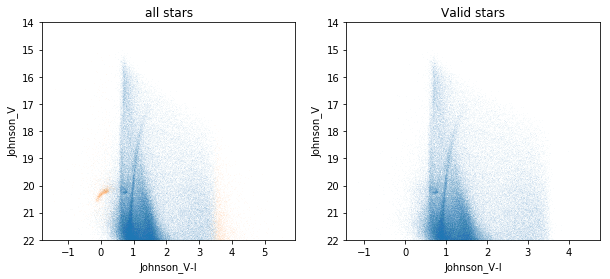

In [21]:
# show the result of conversion

fig,axes = plt.subplots(1,2,figsize=(10,4))
kwargs = {"s":0.01,"alpha":0.1,"ax":axes[0]}

np_not = np.logical_not
#valid_J = df_des_photometry.Johnson_VALID
valid_des = df_des_redden_photometry.VALID_des_to_sdss
#is_valid = valid_J & valid_des

#df_des_photometry.plot.scatter("Johnson_V-I","Johnson_I",**kwargs)
#df_des_photometry[valid_J & valid_des].plot.scatter("Johnson_V-I","Johnson_I",**kwargs)
df_des_redden_photometry[valid_des].plot.scatter("Johnson_V-I","Johnson_V",**kwargs)
#df_des_photometry[valid_J & lgc_not(valid_des)].plot.scatter("Johnson_V-I","Johnson_I",**kwargs,c="C1")
df_des_redden_photometry[np.logical_not(valid_des)].plot.scatter("Johnson_V-I","Johnson_V",**kwargs,c="C1")
#df_des_photometry[lgc_not(valid_J) & valid_des].plot.scatter("Johnson_V-I","Johnson_I",**kwargs,c="C2")
#df_des_photometry[lgc_not(valid_J) & lgc_not(valid_des)].plot.scatter("Johnson_V-I","Johnson_I",**kwargs,c="C3")
plt.ylim([22,14])
axes[0].set_title("all stars")
#axes[0].legend(["blue:valid","orange:invalid(des->sdss)","green:invalid(sdss->Johnson)","red:invalid(both)"])
axes[0].set_ylim([22,14])
#plt.show()

#df_des_photometry[valid_J & valid_des].plot.scatter("Johnson_V-I","Johnson_I",s=0.1,alpha=0.1,ax=axes[1])
df_des_redden_photometry[valid_des].plot.scatter("Johnson_V-I","Johnson_V",s=0.01,alpha=0.1,ax=axes[1])
axes[1].set_title("Valid stars")
axes[1].set_ylim([22,14])
plt.show()

In [23]:
import cmd_utilities
poly_x,poly_y = np.loadtxt("CMD_cut_ours.csv",delimiter=",").T
poly_x,poly_y

(array([1.33007335, 1.1002445 , 0.7       , 1.17      , 1.29894503,
        1.54514172, 1.33007335]),
 array([17.58606557, 18.48360656, 20.5       , 20.5       , 18.75688752,
        17.49749545, 17.58606557]))

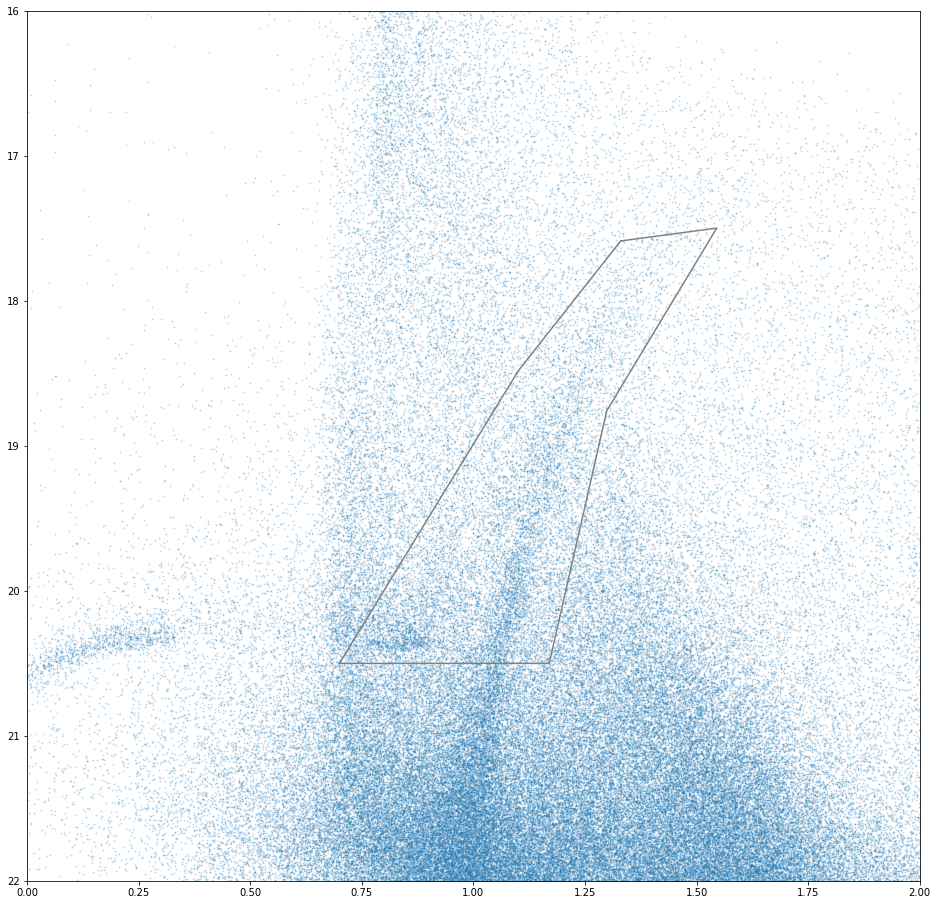

In [25]:
# DES - Walker
dVmI = -0.106727
dV = -0.127383

plt.figure(figsize=(16,16))
plt.scatter(df_des_redden_photometry["Johnson_V-I"]-dVmI,df_des_redden_photometry["Johnson_V"]-dV,s=1,alpha=0.2)
#plt.scatter(df_walker["V-I"],df_walker["Vmag"],s=5,alpha=1,marker=".")
plt.plot(poly_x,poly_y,c="gray")
plt.ylim([22,16])
plt.xlim([0,2])
plt.show()

In [26]:
df_des_redden_photometry["Walker_V-I"] = df_des_redden_photometry["Johnson_V-I"]-dVmI
df_des_redden_photometry["Walker_V"] = df_des_redden_photometry["Johnson_V"]-dV
df_des_redden_photometry.to_csv("data/des_photometry_wide.csv",index=None)